In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit    

In [2]:
lc1 = np.genfromtxt('Data/tess_lc1.dat', skip_header = 1)
lc2 = np.genfromtxt('Data/tess_lc2.dat', skip_header = 1)

In [3]:
# define the cleaning function
def data_cleaning(data):
    test = ~np.isnan(data).any(axis = 1)
    data = data[test]
    
    return data
    

In [4]:
lc1 = data_cleaning(lc1)
lc2 = data_cleaning(lc2)

In [5]:
mpl.rcParams.update({'font.size': 14, 'axes.labelsize': 12, 'axes.titlesize': 16})

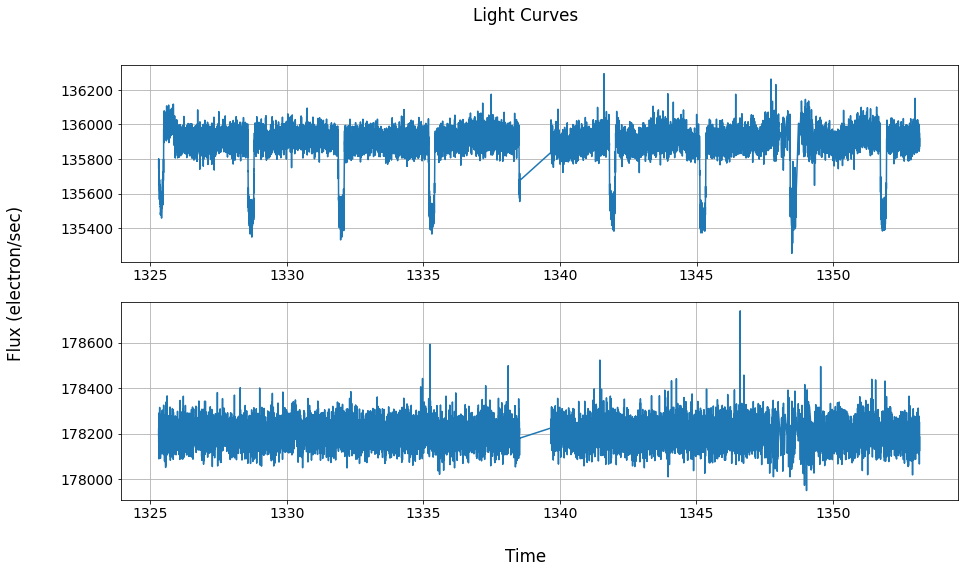

In [6]:
fig = plt.figure(figsize=(15,8))

plt.subplot(2,1,1)
plt.plot(lc1[:,0], lc1[:,1])
# plt.tight_layout()
plt.grid()

plt.subplot(2,1,2)
plt.plot(lc2[:,0], lc2[:,1])
# plt.tight_layout()
plt.grid()

fig.supxlabel('Time')
fig.supylabel('Flux (electron/sec)')
fig.suptitle('Light Curves')
plt.show()

In [7]:
# define the smoothing function
def smoothing(data):
    data_smooth = []
    for i in range(1, len(lc1)-2):
        av_t = (data[i,0]+ data[i+1,0]+ data[i+2,0] + data[i-1,0])/4
        av_f = (data[i,1]+ data[i+1,1]+ data[i+2,1] + data[i-1,1])/4
        data_smooth.append([av_t, av_f])
    data_smooth = np.array(data_smooth)
    return data_smooth


# moving average with np.convolute()
def moving_average(x, w):
    av_t = np.convolve(x[:,0], np.ones(w), 'valid') / w 
    av_f = np.convolve(x[:,1], np.ones(w), 'valid') / w
    
    return av_t, av_f

In [8]:
lc1_smooth = moving_average(lc1, 4)
lc2_smooth = moving_average(lc2, 4)

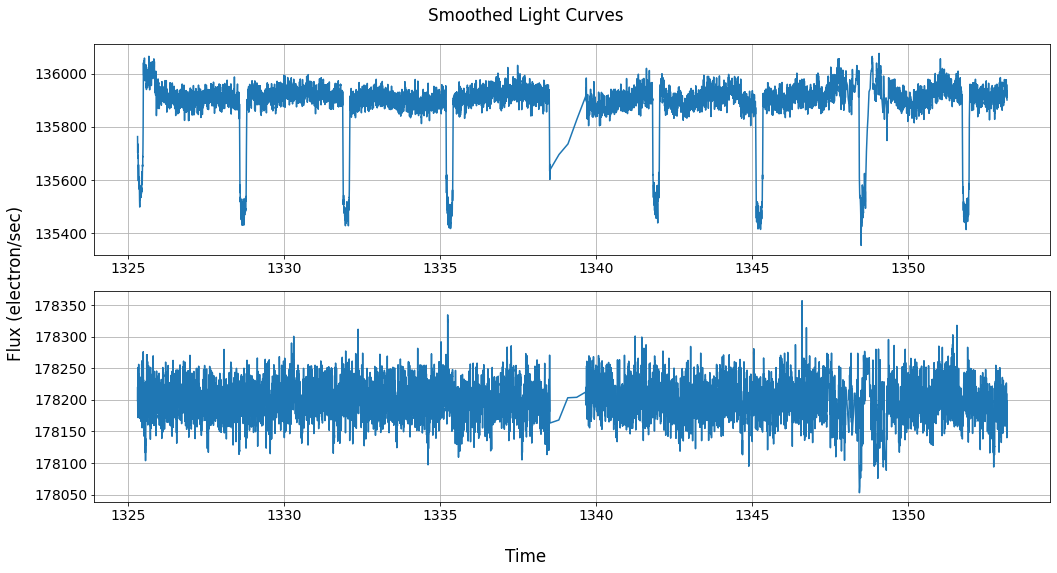

In [9]:
fig = plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
plt.plot(lc1_smooth[0], lc1_smooth[1])
plt.grid()

plt.subplot(2,1,2)
plt.plot(lc2_smooth[0], lc2_smooth[1])

fig.supxlabel('Time')
fig.supylabel('Flux (electron/sec)')
fig.suptitle('Smoothed Light Curves')
plt.tight_layout()
plt.grid()
plt.show()

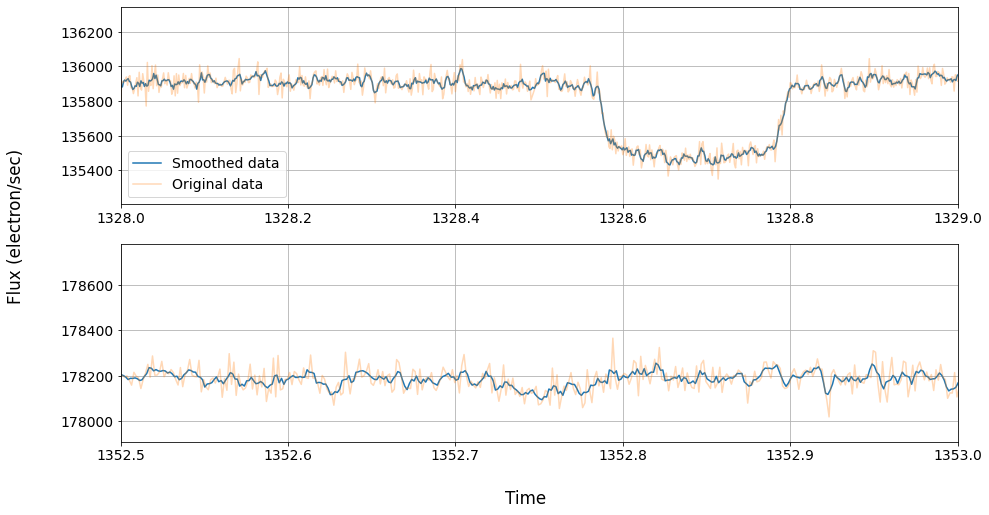

In [10]:
# We are focusing on one trasit (for each system) from the total time series 
# and we plot this part for the smootheed lines together with the original data.  

# plot one eclipse for lc1
fig = plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
plt.plot(lc1_smooth[0], lc1_smooth[1], label = 'Smoothed data')
plt.plot(lc1[:,0], lc1[:,1], alpha = 0.3, label = 'Original data')
plt.xlim([1328, 1329])
plt.grid()
plt.legend()


plt.subplot(2,1,2)
plt.plot(lc2_smooth[0], lc2_smooth[1])
plt.plot(lc2[:,0], lc2[:,1], alpha = 0.3)
plt.xlim([1352.5, 1353])

fig.supxlabel('Time')
fig.supylabel('Flux (electron/sec)')
# plt.tight_layout()
plt.grid()
plt.show()

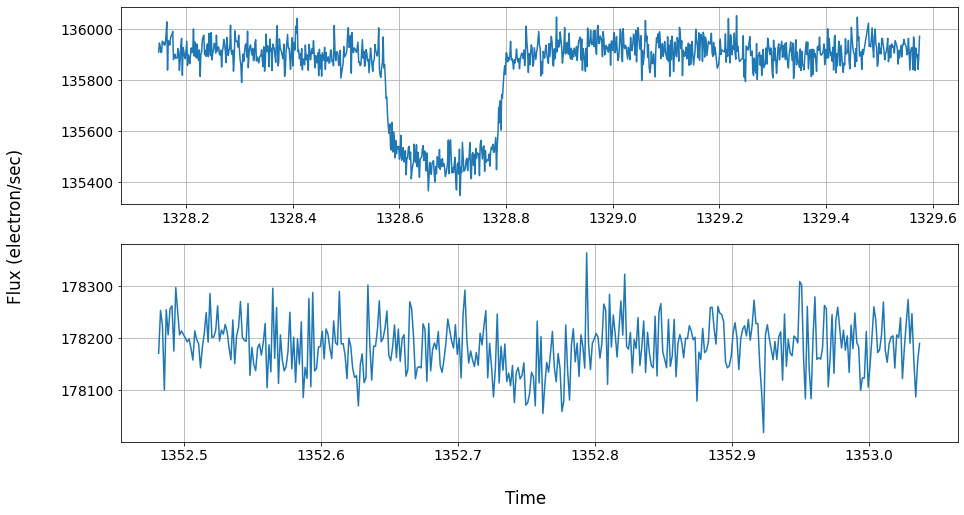

In [11]:
# plot part of the data (lc1)
fig = plt.figure(figsize=(15,8))
plt.subplot(2,1,1)
lc1_part = lc1[2000:3000]
plt.plot(lc1_part[:,0], lc1_part[:,1])
plt.grid()

# Again for lc2 flux
plt.subplot(2,1,2)
lc2_part = lc2[17600:18000]
plt.plot(lc2_part[:,0], lc2_part[:,1])
plt.grid()

fig.supxlabel('Time')
fig.supylabel('Flux (electron/sec)')

plt.show()

In [12]:
# define the function
def flux_function(t, Δtotal, Δt_in, t_cent, d, f_star):
    Δt_d = Δtotal - 2*Δt_in
    t_in_d = t_cent - Δt_d/2
    t_er_d = t_cent + Δt_d/2
    t_in_u = t_in_d - Δt_in
    t_er_u = t_er_d + Δt_in
    
    f_d = f_star - d
    
    grad_in = (f_d - f_star)/(t_in_d - t_in_u)
    grad_er = - grad_in
    
    
    y = np.zeros(len(t)) 

    y[t < t_in_u] = f_star
    y[(t >= t_in_u) & (t < t_in_d)] = grad_in*(t[(t >= t_in_u) & (t < t_in_d)]-t_in_u)+f_star
    y[(t >= t_in_d) & (t < t_er_d)] = f_d
    y[(t >= t_er_d) & (t < t_er_u)] = grad_er*(t[(t >= t_er_d) & (t < t_er_u)]-t_er_d)+f_d
    y[t >= t_er_u] = f_star
    
    return y

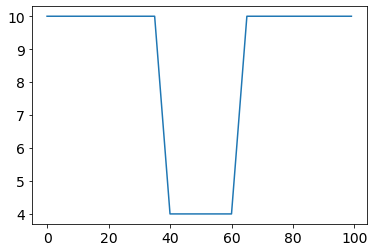

In [13]:
# test the function
t = np.arange(100)
f = flux_function(t, 30, 5, 50, 6, 10)
plt.plot(t,f)
plt.show()

In [99]:
#    [Δtotal, Δt_in, t_cent, d, f_star]

p0_lc1 = [0.3, 0.05, 1328.7, 5000, 136000] # initial parameters for the flux_function
popt_lc1, _ = curve_fit(flux_function, lc1_part[:,0], lc1_part[:,1], p0_lc1) # fit

p0_lc2 = [0.1, 0.03, 1352.75, 200, 178200] # initial parameters for the flux_function (lc2 case)
popt_lc2, _ = curve_fit(flux_function, lc2_part[:,0], lc2_part[:,1], p0_lc2) # fit

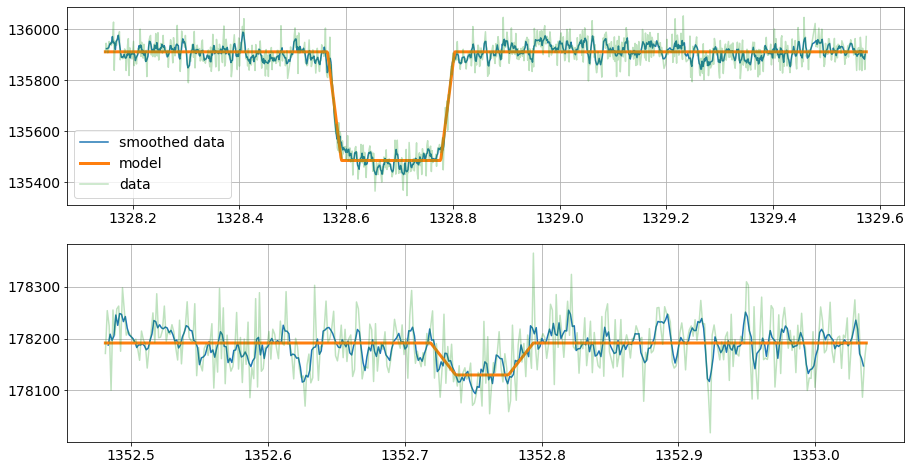

In [105]:
# plotting the data with the model 
fig = plt.figure(figsize = (15,8))
plt.subplot(2,1,1)
plt.plot(moving_average(lc1_part,4)[0], moving_average(lc1_part,4)[1], label = 'smoothed data')
plt.plot(lc1_part[:,0], flux_function(lc1_part[:,0], *popt_lc1), linewidth = 3, label = 'model')
plt.plot(lc1_part[:,0], lc1_part[:,1], label = 'data', alpha = .3)
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(moving_average(lc2_part,4)[0], moving_average(lc2_part,4)[1], label = 'smoothed_data')
plt.plot(lc2_part[:,0], flux_function(lc2_part[:,0], *popt_lc2), linewidth = 3, label = 'model')
plt.plot(lc2_part[:,0], lc2_part[:,1], label = 'data lc2', alpha = 0.3)
plt.grid()
plt.show()

In [80]:
#    [Δtotal, Δt_in, t_cent, d, f_star]
p0 = [0.1, 0.03, 1352.75, 200, 178200] # initial parameters for the flux_function (lc2 case)
popt, pcov = curve_fit(flux_function, lc2_part[:,0], lc2_part[:,1], p0) # fit

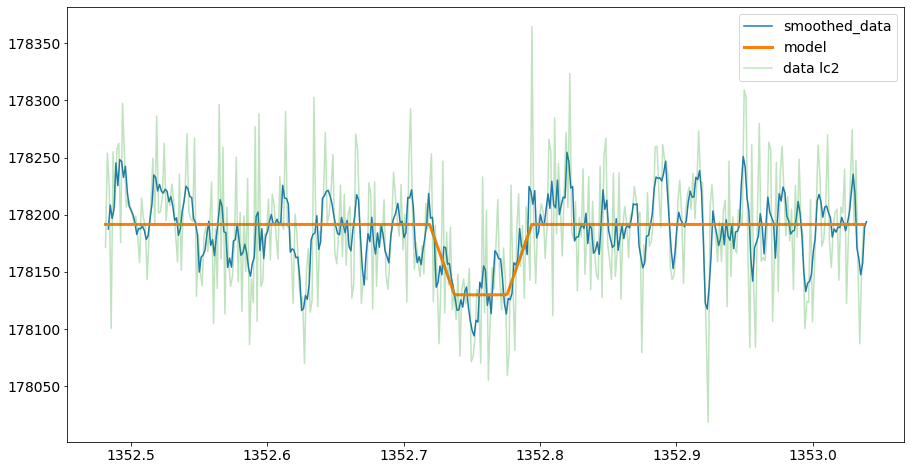

In [89]:
# plotting the data with the model 
fig = plt.figure(figsize = (15,8))
plt.plot(lc2_smooth[0][17600:18000], lc2_smooth[1][17600:18000], label = 'smoothed_data')

plt.plot(lc2_part[:,0], flux_function(lc2_part[:,0], *popt), linewidth = 3, label = 'model')
plt.plot(lc2_part[:,0], lc2_part[:,1], label = 'data lc2', alpha = 0.3)

plt.legend()
plt.show()